In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context
import numpy as np
from datetime import datetime
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [0]:
mnist_data = keras.datasets.mnist
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10
input_shape = (img_rows, img_cols, 1)

In [0]:
def preprocessData():
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist_data.load_data()

    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

    # # Input for others
    # else:
    #   x_train = x_train.reshape(60000, 784)
    #   x_test = x_test.reshape(10000, 784)

    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")
    x_train /= 255
    x_test /= 255

    print("x_train shape:", x_train.shape)
    print(x_train.shape[0], "train samples")
    print(x_test.shape[0], "test samples")
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test

In [0]:
x_train, y_train, x_test, y_test = preprocessData()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
def splitData(x_train,y_train,size):
  # Shuffle data randomly
  indexes = np.arange(size)
  np.random.shuffle(indexes)
  x = x_train[indexes]
  y = y_train[indexes]
  x_a = x[0:size//2]
  x_b = x[size//2:]
  y_a = y[0:size//2]
  y_b = y[size//2:]
  return x_a, x_b, y_a,y_b

In [0]:
x_a, x_b, y_a,y_b = splitData(x_train,y_train,60000)

In [0]:
class CNN:
    def __init__(self, batch_size = 128, epochs=20, dropout=False, BN=False):
        self.model = keras.Sequential()
        # the data, split between train and test sets
        self.batch_size = batch_size
        self.epochs = epochs
        self.dropout = dropout
        self.BN = BN
      
    def create_model(self):
        self.model.add(
            layers.Conv2D(32, (3, 3), activation="relu", padding='same',input_shape=input_shape)
        )
        self.dropout_BN_Layer()
        self.model.add(layers.MaxPooling2D((2, 2)))
        
        self.model.add(layers.Conv2D(64, (3, 3),padding='same', activation="relu"))        
        self.dropout_BN_Layer()
        self.model.add(layers.MaxPooling2D((2, 2)))
        
        self.model.add(layers.Conv2D(64, (3, 3),padding='same', activation="relu"))
        self.dropout_BN_Layer()
        
        self.model.add(layers.Flatten())
        
        self.model.add(layers.Dense(64))
        self.dropout_BN_Layer()
        self.model.add(layers.Activation('relu'))
        
        self.model.add(layers.Dense(10, activation="softmax"))
        print("CNN")
        return self.model

    def dropout_BN_Layer(self):
        if self.BN:
            self.model.add(layers.BatchNormalization())
        if self.dropout:
            self.model.add(layers.Dropout(0.5))

    def train_model(self, x_train, y_train, x_test, y_test,tb):
     
        self.model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )
        logdir = "logs/scalars/CNN"
        tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir) 
        self.model.fit(
            x_train,
            y_train,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[tb],
        )

In [0]:
# train with x_a
cnn_a = CNN(dropout=False, BN=True)
model_a = cnn_a.create_model()
tb1= TensorBoard(log_dir='./logs_1/model_a', histogram_freq=0, write_graph=True, write_images=True)
cnn_a.train_model(x_a, y_a, x_test, y_test,tb1)

# train with x_b
cnn_b = CNN(dropout=False, BN=True)
model_b = cnn_b.create_model()
tb2= TensorBoard(log_dir='./logs_1/model_b', histogram_freq=0, write_graph=True, write_images=True)
cnn_b.train_model(x_b, y_b, x_test, y_test,tb2)

CNN
Train on 30000 samples, validate on 10000 samples
Epoch 1/20
30000/30000 [==============================] - 4s 132us/sample - loss: 0.1728 - accuracy: 0.9615 - val_loss: 2.3203 - val_accuracy: 0.2227
Epoch 2/20
30000/30000 [==============================] - 2s 79us/sample - loss: 0.0404 - accuracy: 0.9903 - val_loss: 0.1540 - val_accuracy: 0.9661
Epoch 3/20
30000/30000 [==============================] - 2s 80us/sample - loss: 0.0223 - accuracy: 0.9948 - val_loss: 0.0505 - val_accuracy: 0.9844
Epoch 4/20
30000/30000 [==============================] - 2s 80us/sample - loss: 0.0141 - accuracy: 0.9969 - val_loss: 0.0447 - val_accuracy: 0.9864
Epoch 5/20
30000/30000 [==============================] - 2s 80us/sample - loss: 0.0106 - accuracy: 0.9977 - val_loss: 0.0316 - val_accuracy: 0.9903
Epoch 6/20
30000/30000 [==============================] - 2s 80us/sample - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0300 - val_accuracy: 0.9904
Epoch 7/20
30000/30000 [===========================

In [0]:
model_a.save('model_a.h5')
model_b.save('model_b.h5')

In [0]:
model_a.evaluate(x=x_a, y=y_a)

30000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0012000660093050102, 0.9997]

In [0]:
model_b.evaluate(x=x_a, y=y_a)

30000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.032950611785896276, 0.9914333]

In [0]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label,model):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [0]:
x_a = tf.convert_to_tensor(x_a, dtype=tf.float32)
image_probs = model_a.predict(x_a)
# print(image_probs)
perturbations = create_adversarial_pattern(x_a, image_probs,model=model_a)

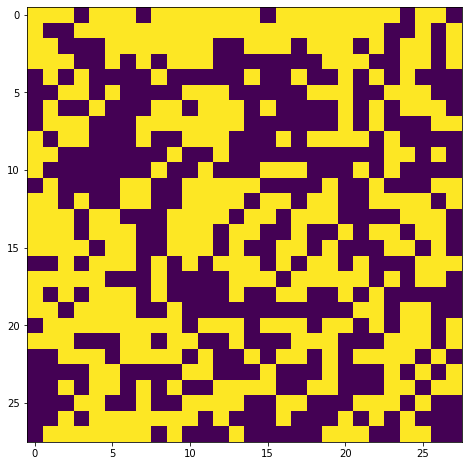

In [0]:
index = np.random.randint(10000)
plt.imshow(tf.squeeze(perturbations[index]))

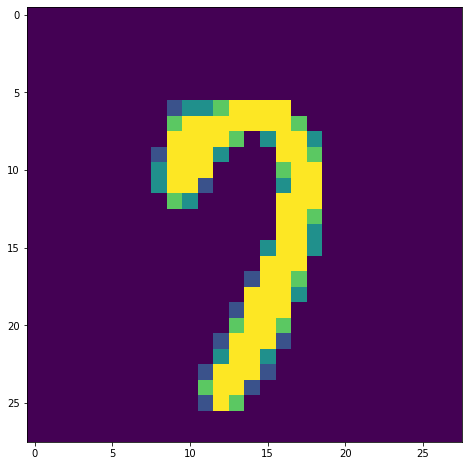

In [0]:
plt.imshow(tf.squeeze(x_a[index]))

In [0]:
def FSGM(img, perturbation,epsilons):
  adv_x = img + perturbations * epsilons
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  return adv_x

In [0]:
adversarial_imgs = FSGM(x_a,perturbations,0.3)

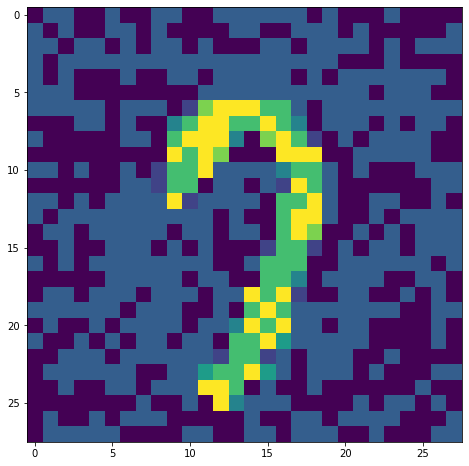

In [0]:
plt.imshow(tf.squeeze(adversarial_imgs[index]))

In [0]:
adver = tf.reshape(adversarial_imgs[index],[1,28,28,1])
origin = tf.reshape(x_a[index],[1,28,28,1])
print("Adversarial Example result")
print(model_a.predict(adver).argmax())
print("Original Example result")
print(model_a.predict(origin).argmax())

Adversarial Example result
4
Original Example result
4


In [0]:
# model A attack result
result = model_a.predict(adversarial_imgs)
_result = model_a.predict(x_a)

a_lable = np.argmax(result,axis=1)
t_lable = np.argmax(_result,axis=1)
total = a_lable.shape[-1]
success_attack = total - np.sum(a_lable == t_lable)
print(success_attack)
print(success_attack/total * 100 )

# model B attack result
result_b = model_b.predict(adversarial_imgs)
_result_b = model_b.predict(x_a)

a_lable_b = np.argmax(result_b,axis=1)
t_lable_b = np.argmax(_result_b,axis=1)
total = a_lable_b.shape[-1]
success_attack = total - np.sum(a_lable_b == t_lable_b)
print(success_attack)
print(success_attack/total * 100 )

21233
70.77666666666667
19701
65.67


In [0]:
model_a.evaluate(adversarial_imgs,y_a)

30000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[8.896883739217122, 0.29216668]

In [0]:
model_b.evaluate(adversarial_imgs,y_a)

30000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[5.883030558776856, 0.34316668]

In [0]:
import imageio
ad_imgs = tf.squeeze(adversarial_imgs)
filename = 0
for img in ad_imgs:
  img = img.numpy()
  # if filename == 0:
  #   print(img)
  img = 255 * img
  img = img.astype(np.uint8)
  imageio.imwrite(f'{filename}.jpg', img)
  filename = filename+1
  if filename == 99:
    break

In [0]:
def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(fig_id+"_adversarial_plot.png", format='png', dpi=300)

In [0]:
import matplotlib.patches as patches
def plot_result(plot_num,model, adversarial_imgs, adversarial_lable, original_lable, plot_name):
  fig, axes = plt.subplots(plot_num, plot_num,figsize=(28,28))
  imgs = tf.squeeze(adversarial_imgs)
  for x in range(plot_num):
    for y in range(plot_num):
      al = adversarial_lable[x*plot_num + y]
      ol = original_lable[x*plot_num + y]
      if al == ol:
        rect = patches.Rectangle((0,0),27,27,linewidth=10,edgecolor='r',facecolor='none')
      else:
        rect = patches.Rectangle((0,0),27,27,linewidth=10,edgecolor='g',facecolor='none')        
      axes[x, y].imshow(imgs[x*plot_num + y])
      axes[x, y].add_patch(rect)
      axes[x, y].set_title(f'{al} ({ol})')
         
  save_fig(plot_name)

Saving figure model_a
Saving figure model_b


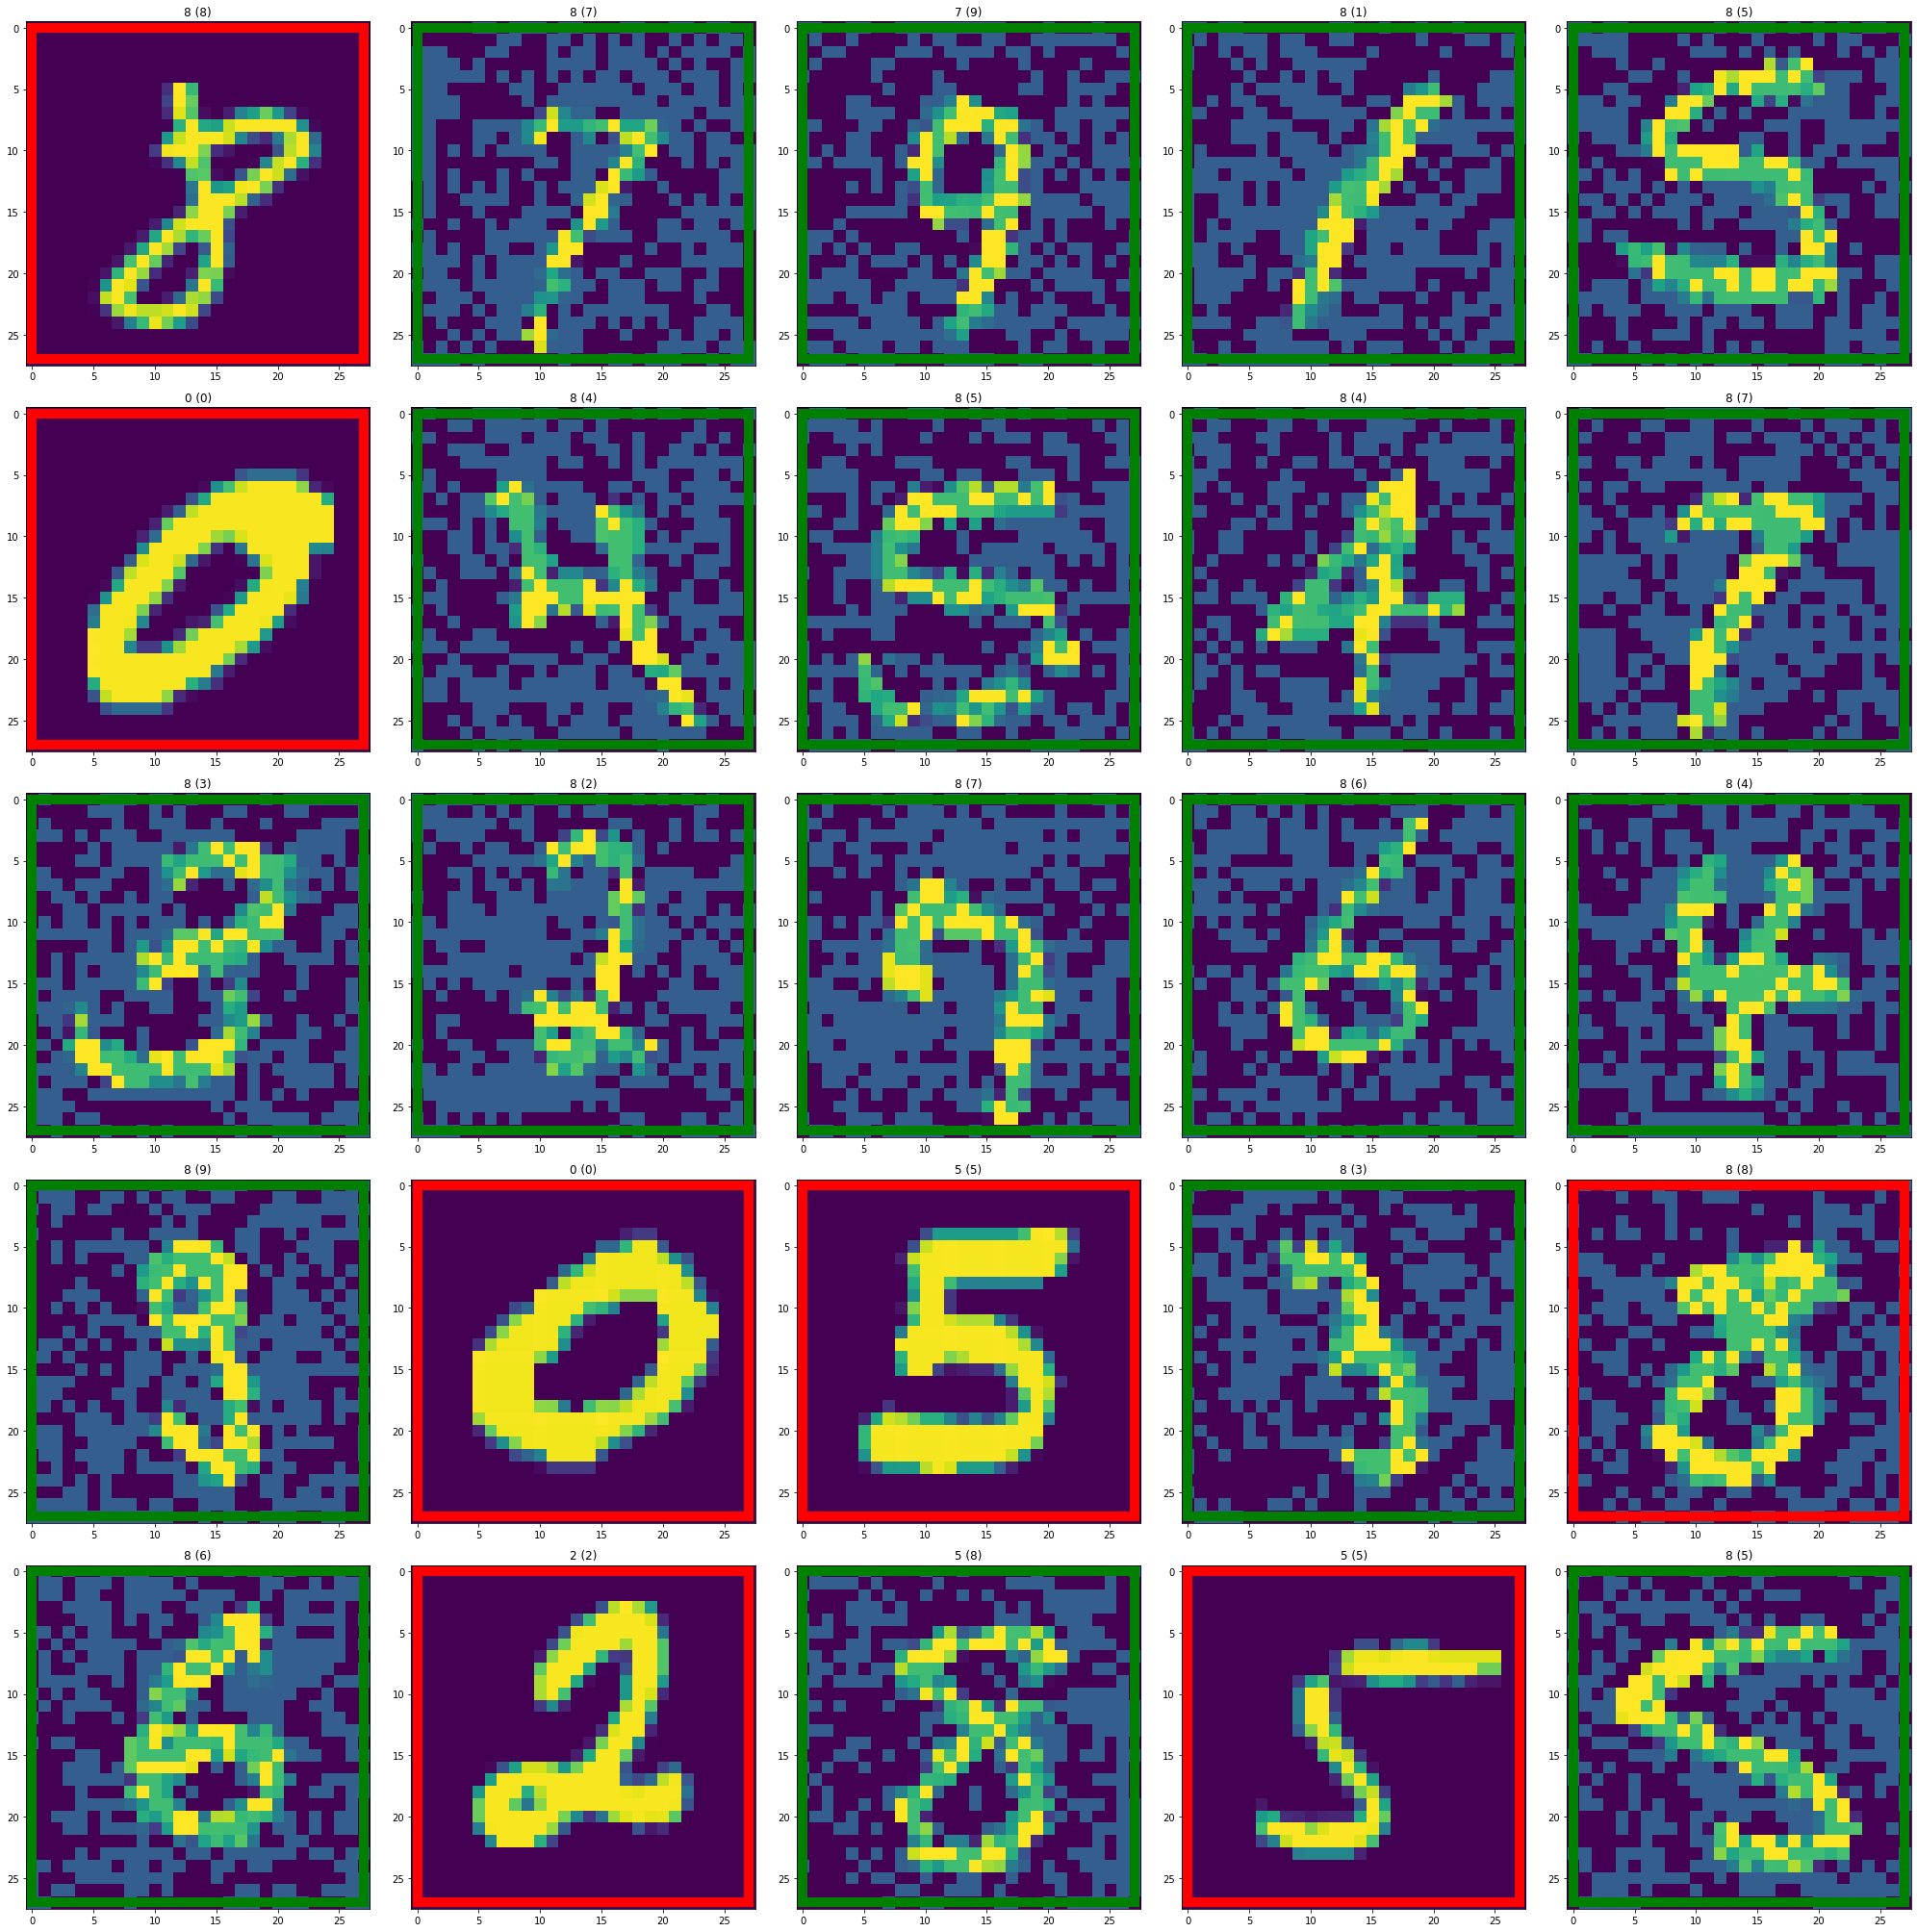

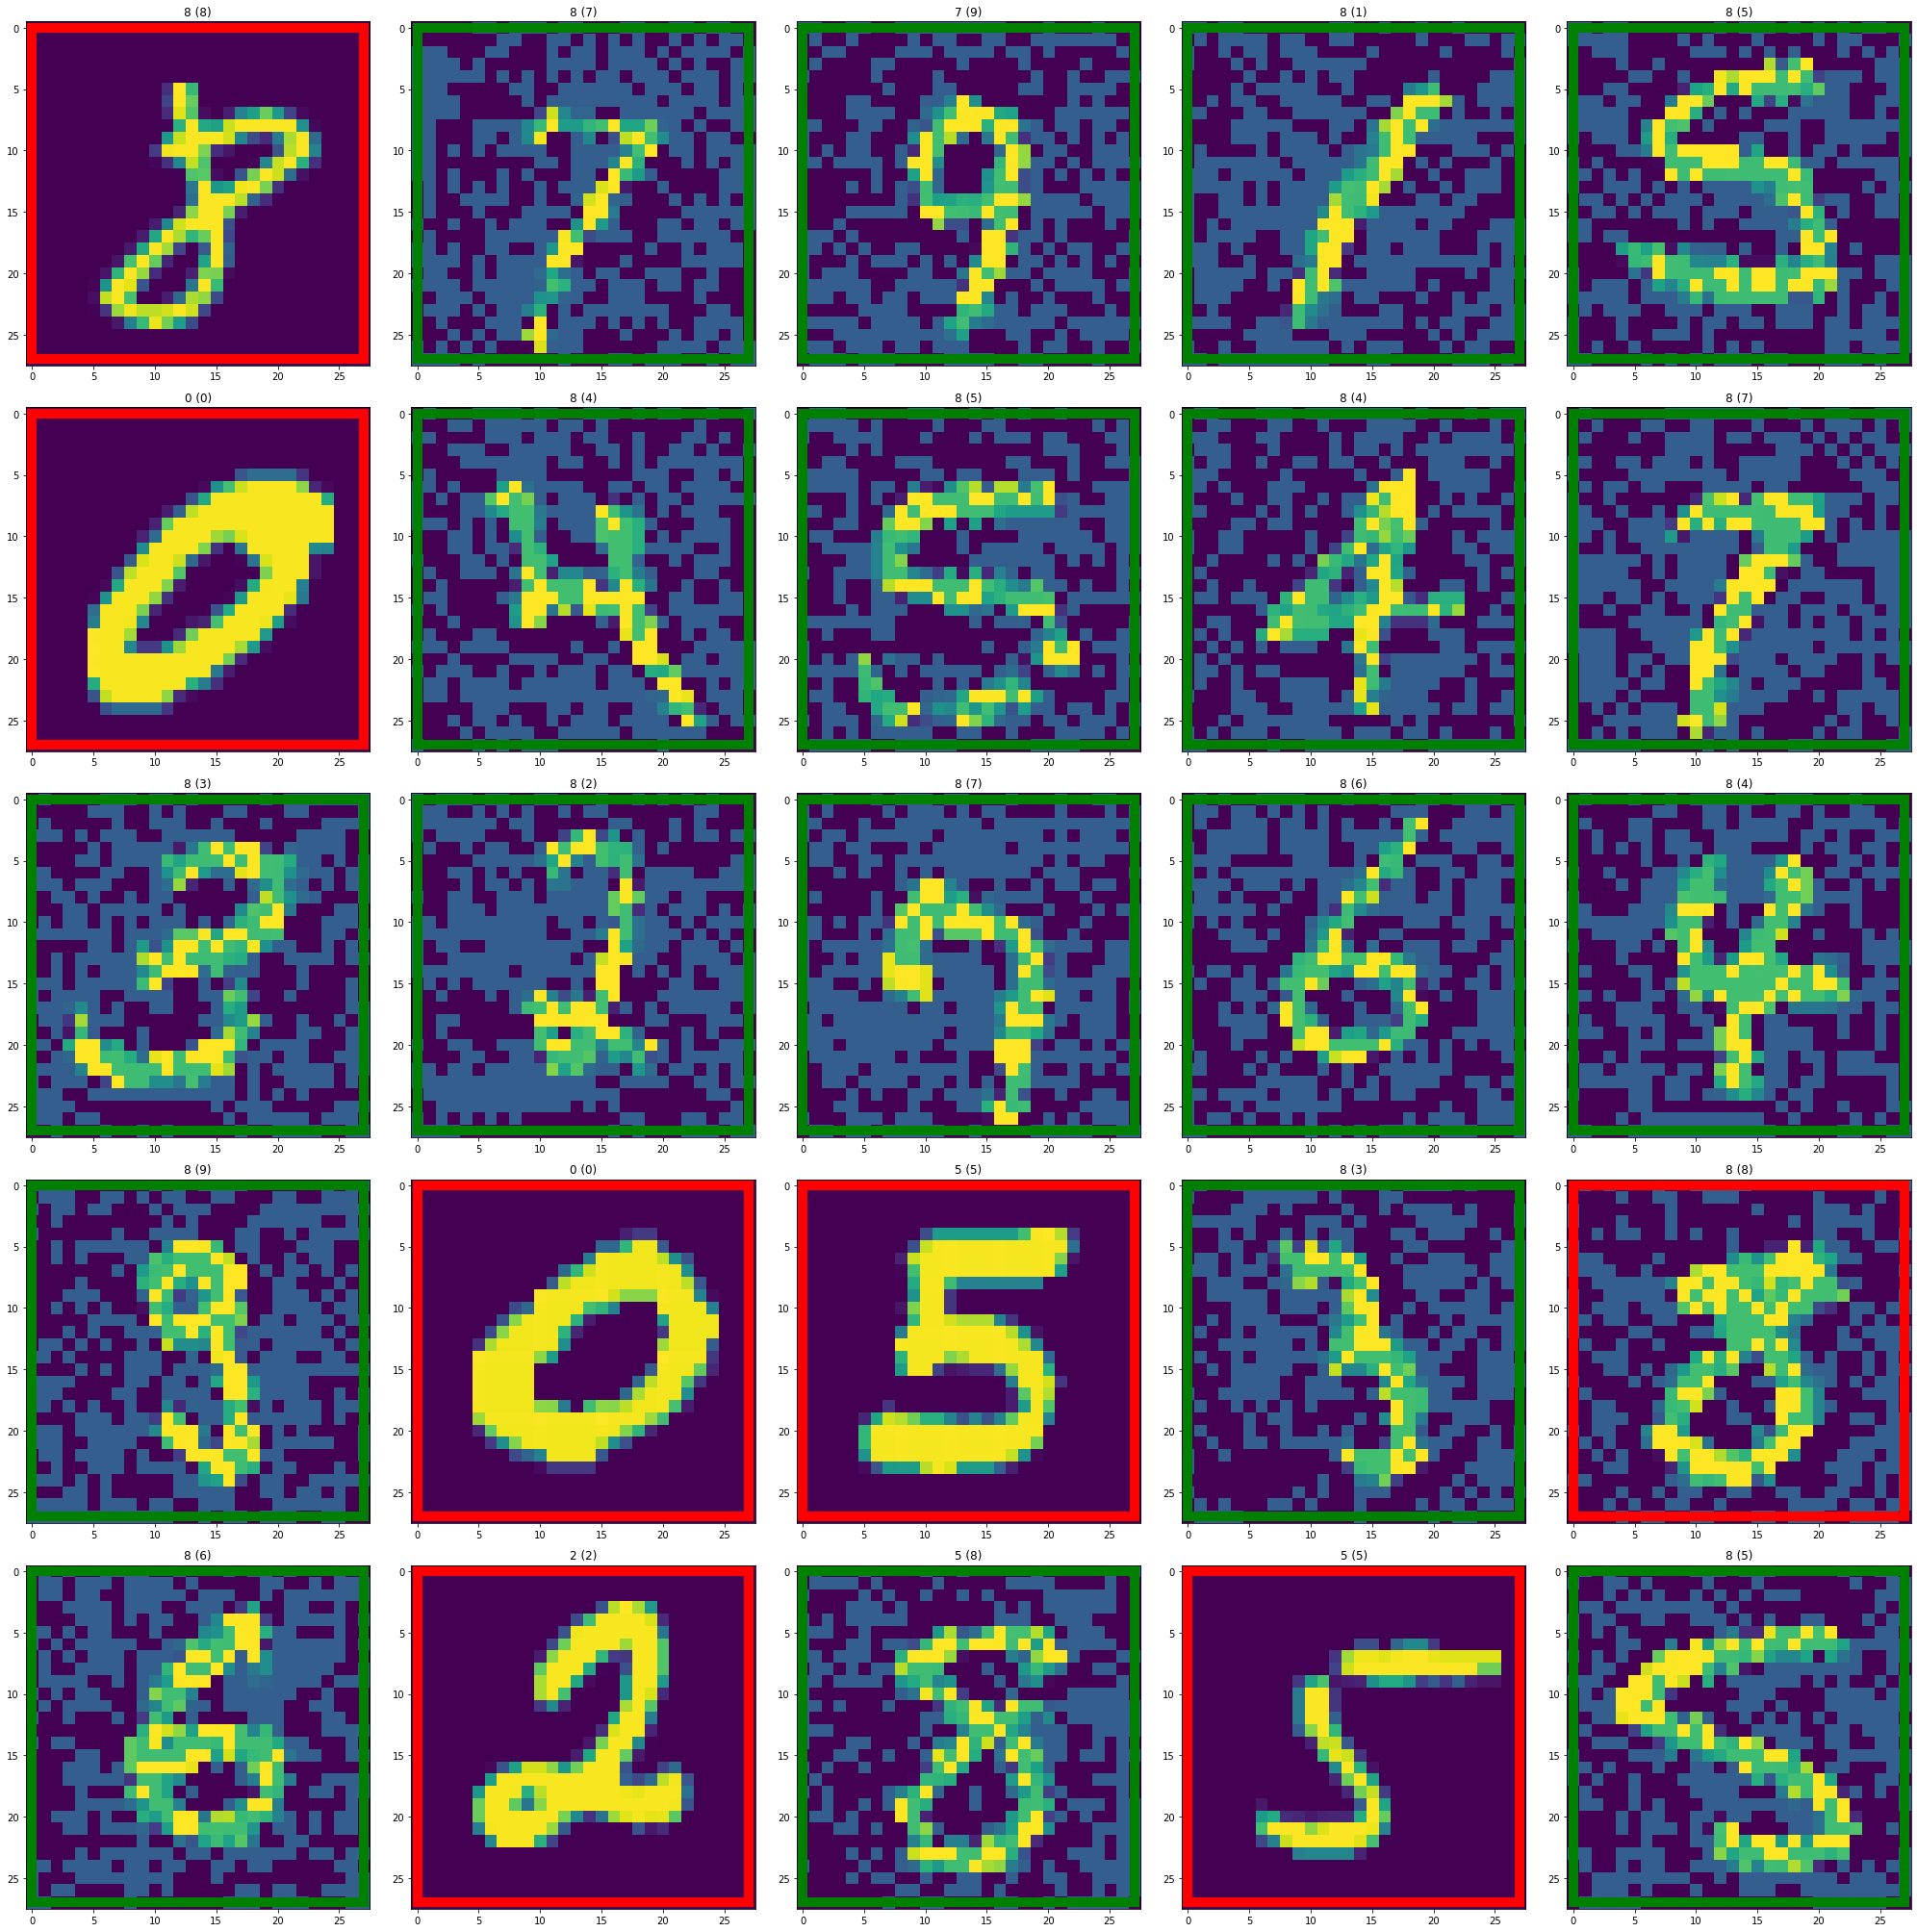

In [0]:
img_per_row = 5
# offset = np.random.randint(30000-img_per_row*img_per_row)
offset = 1
adv_imgs = adversarial_imgs[offset:offset+img_per_row*img_per_row]
adv_lable_a = a_lable[offset:offset+img_per_row*img_per_row]
org_lable_a = t_lable[offset:offset+img_per_row*img_per_row]
adv_lable_b = a_lable[offset:offset+img_per_row*img_per_row]
org_lable_b = t_lable[offset:offset+img_per_row*img_per_row]

plot_result(5,model_a,adv_imgs,adv_lable_a,org_lable_a,"model_a")                  
plot_result(5,model_b,adv_imgs,adv_lable_b,org_lable_b,"model_b")


In [0]:
!zip  file.zip *.jpg